# Overfitting in Random Forests 
## Part 2 - Classification

Dr Jose M Albornoz, May 2019

A Random Forest with only one tree will overfit to data because it is the same as a single decision tree. When we add trees to the Random Forest then the tendency to overfitting should decrease (thanks to bagging and random feature selection). However, the generalization error will not go to zero. The variance of generalization error will approach to zero with more trees added but the bias will not.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

import numpy as np
RANDOM_STATE = 801

# 1.- Generate data

We will be using an imbalanced dataset where the positive class appears in a 5% proportion.

In [2]:
X, y = make_classification(n_samples=5000, n_features=10, n_informative=2, n_redundant=2, weights=[0.95, 0.05])

In [3]:
np.bincount(y)

array([4724,  276])

# 2.- Split into training and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

# 3.- Random forest model

We will train two models: one with full trees and one with pruning controlled by *min_samples_leaf* hyper-parameter. 

## 3.1.- Full trees random forest

In [5]:
rf = RandomForestClassifier(n_estimators=10)

rf.fit(X_train, y_train)

y_train_predicted = rf.predict(X_train)
y_test_predicted_full_trees = rf.predict(X_test)

mse_train = precision_score(y_train, y_train_predicted)
mse_test = precision_score(y_test, y_test_predicted_full_trees)
print("RF with full trees, Train precision: {}; Test precision: {}".format(mse_train, mse_test))

RF with full trees, Train precision: 0.9940828402366864; Test precision: 0.7402597402597403


## 3.2.- Pruned trees random forest

In [6]:
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=25)

rf.fit(X_train, y_train)

y_train_predicted = rf.predict(X_train)
y_test_predicted_pruned_trees = rf.predict(X_test)

mse_train = precision_score(y_train, y_train_predicted)
mse_test = precision_score(y_test, y_test_predicted_pruned_trees)
print("RF with pruned trees, Train MSE: {}; Test MSE: {}".format(mse_train, mse_test))

RF with pruned trees, Train MSE: 0.7985074626865671; Test MSE: 0.6984126984126984


We have clear evidence of overfitting - the RF with full trees has a perfect score on the training set; additionally the spread between training and testing scores is smaller in the pruned trees

# 4.- Overfitting vs number of trees

Let's check how the random forest model will behaves with an increasing number of trees. We will train the RF model starting with 1 tree and add 1 tree in each loop iteration: in every step, we will measure MSE on train and test data.

## 4.1.- Increasing number of trees, full random forest

In [7]:
rf = RandomForestClassifier(n_estimators=1)

n_trees = []
precision_train_full = []
precision_test_full = []

for iter in range(30):

    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    
    precision_train_full.append(precision_score(y_train, y_train_predicted))
    precision_test_full.append(precision_score(y_test, y_test_predicted))
        
    rf.n_estimators += 1
    n_trees.append(rf.n_estimators)

(0.65, 1.05)

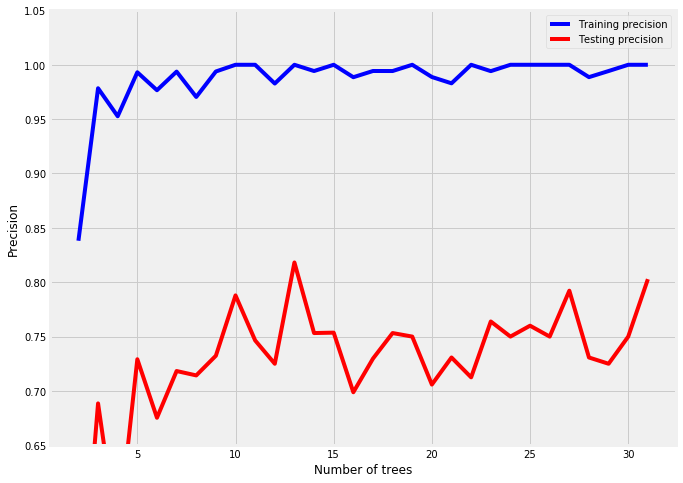

In [8]:
plt.figure(figsize=(10,8))
plt.plot(n_trees, precision_train_full, color='b', label='Training precision')
plt.plot(n_trees, precision_test_full, color='r', label='Testing precision')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.ylim(0.65, 1.05)

## 4.2.- Increasing number of trees, pruned random forest

In [9]:
rf = RandomForestClassifier(n_estimators=1, min_samples_leaf=25)

n_trees = []
precision_train_pruned = []
precision_test_pruned = []

for iter in range(30):

    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    
    precision_train_pruned.append(precision_score(y_train, y_train_predicted))
    precision_test_pruned.append(precision_score(y_test, y_test_predicted))
        
    rf.n_estimators += 1
    n_trees.append(rf.n_estimators)

(0.65, 1.05)

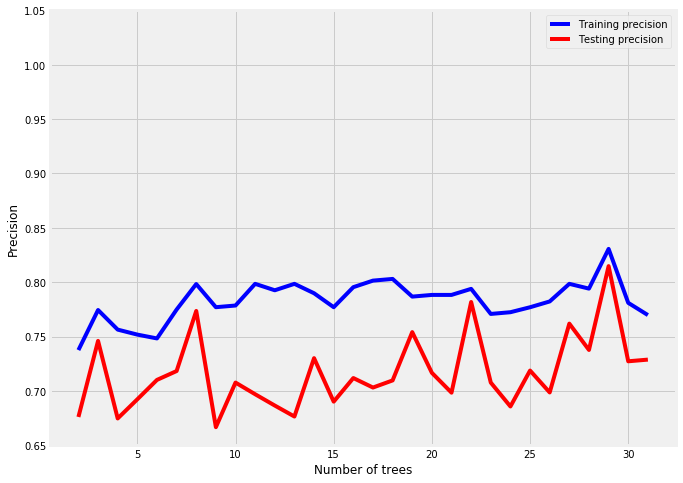

In [10]:
plt.figure(figsize=(10,8))
plt.plot(n_trees, precision_train_pruned, color='b', label='Training precision')
plt.plot(n_trees, precision_test_pruned, color='r', label='Testing precision')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.ylim(0.65, 1.05)

We can see how using a random forest with full trees clearly overfits the data, as evidenced by the difference between training and test MSEs. The pruning of the tree helps us control this overfit.

# 5.- Controlling Random Forest overfitting through grid search and cross-validation

We will now see how grid search and crossvalidation can be used to find an optimal random forest model.

In [11]:
n_trees = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
max_depth = [5, 10, 15, 20, 25, 30]
min_samples_leaf = [10, 15, 20, 25, 30, 35, 40, 45, 50]
param_grid = [{'n_estimators': n_trees, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}]

In [12]:
rf = RandomForestClassifier()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

In [13]:
gs = gs.fit(X_train, y_train)

In [14]:
print(gs.best_score_)

0.808484977984978


In [15]:
print(gs.best_params_)

{'max_depth': 25, 'min_samples_leaf': 35, 'n_estimators': 50}


In [16]:
clf = gs.best_estimator_

In [17]:
clf.fit(X_test, y_test)
print('Test precision: %.3f' % clf.score(X_test, y_test))

Test precision: 0.962


We see how the grid search produced an optimal combination of parameters that resulted in a model with good generalisation.

In [18]:
print('Train precision: %.3f' % precision_score(y_train, clf.predict(X_train)))
print('Test precision: %.3f' % precision_score(y_test, clf.predict(X_test)))

Train precision: 0.746
Test precision: 0.696
